In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas
import sklearn
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

/usr/lib/python3/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/lib/python3/dist-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [23]:
data_dir = './data/'
train_df = pd.read_csv(data_dir + 'train.csv')
descriptions = train_df.groupby('label').describe()
descriptions.to_csv(data_dir + 'descriptions.csv')
descriptions.head()

Unnamed: 0                                                              \
           count          mean          std   min      25%      50%      75%   
label                                                                          
0        10461.0  12393.232961  7175.574798  10.0  6167.00  12405.0  18632.0   
1         3579.0  12591.977647  7154.479452   1.0  6471.00  12665.0  18778.5   
2         4874.0  12381.087197  7191.670984   3.0  6195.25  12263.5  18579.5   
3         5926.0  12393.294465  7155.495973   0.0  6138.75  12439.5  18486.5   

                  bcced             ...   salutations          urls  \
           max    count      mean   ...           75%  max    count   
label                               ...                               
0      24839.0  10461.0  0.000765   ...           1.0  1.0  10461.0   
1      24837.0   3579.0  0.000000   ...           1.0  1.0   3579.0   
2      24838.0   4874.0  0.004514   ...           1.0  1.0   4874.0   
3      24834.0   5926.0  0.000169   ...           1.0  1.0   5926.0   

                                                             
            mean        std  min   25%   50%    75%     max  
label                                                        
0      27.043495  35.397882  0.0   7.0  19.0   33.0   617.0  
1      79.918692  58.417474  0.0  33.0  71.0  108.0   386.0  
2       7.417932  80.817351  0.0   0.0   2.0    8.0  5532.0  
3      63.188660  53.081205  0.0  22.0  48.0   95.0   332.0  

[4 rows x 72 columns]

In [24]:
import re


for x in train_df['date']:
    if '(GMT+' in x :
        train_df = train_df.replace({'date': {x: x.split('(')[0]}})
reg = '[+-][0-9]{2}[0-9]{2}'
train_df['time_zone'] = train_df['date'].apply(lambda x: re.findall(reg, x))
train_df['date'] = pd.to_datetime(train_df['date'], utc = True)


In [37]:
train_df['time_zone'] = train_df['time_zone'].apply(lambda x: ['+0000'] if len(x)!= 1 else x)
train_df['time_zone'] = train_df['time_zone'].apply(lambda x: x[0])
print(train_df.time_zone)



0        +0000
1        +0000
2        -0800
3        +0530
4        +0000
5        +0000
6        +0530
7        -0500
8        -0500
9        +0800
10       +0000
11       +0530
12       +0000
13       -0500
14       +0530
15       +0530
16       +0530
17       +0000
18       +0530
19       +0000
20       -0600
21       +0000
22       +0000
23       +0000
24       +0530
25       +0530
26       +0530
27       +0000
28       +0000
29       +0000
         ...  
24810    -0800
24811    +0000
24812    +0000
24813    +0530
24814    +0000
24815    +0530
24816    -0700
24817    +0530
24818    +0530
24819    +0000
24820    +0000
24821    -0700
24822    -0600
24823    +0000
24824    +0530
24825    +0000
24826    +0000
24827    +0530
24828    +0000
24829    +0000
24830    +0530
24831    +0000
24832    +0000
24833    +0000
24834    -0700
24835    +0530
24836    +0000
24837    +0000
24838    +0530
24839    +0000
Name: time_zone, Length: 24840, dtype: object


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d5061a6d8>,
      dtype=object)

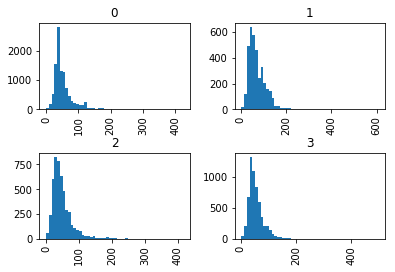

In [30]:
train_df.hist(column='chars_in_subject', by='label', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d50ce7a90>,
      dtype=object)

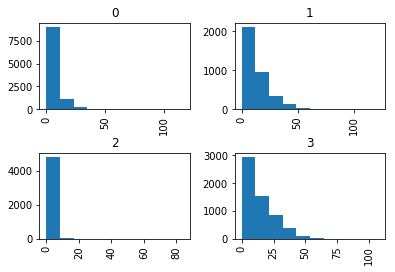

In [5]:
train_df['images_desciption'] = train_df['images'].apply(lambda x: 'no_images' if x == 0 else 'many_images')

train_df.hist(column='images', by='label')

Text(0.5,1,'Class 3')

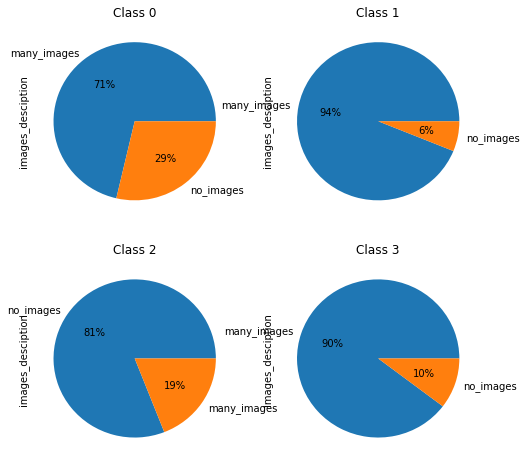

In [6]:
labels = ['few', 'average', 'many']

res0 = train_df[train_df['label'] == 0]['images_desciption'].value_counts()
res1 = train_df[train_df['label'] == 1]['images_desciption'].value_counts()
res2 = train_df[train_df['label'] == 2]['images_desciption'].value_counts()
res3 = train_df[train_df['label'] == 3]['images_desciption'].value_counts()

fig = plt.figure(figsize=(8,8))

fig.add_subplot(2, 2, 1)
res0.plot.pie(autopct='%1.0f%%')
plt.title('Class 0')
fig.add_subplot(2, 2, 2)
res1.plot.pie(autopct='%1.0f%%')
plt.title('Class 1')
fig.add_subplot(2, 2, 3)
res2.plot.pie(autopct='%1.0f%%')
plt.title('Class 2')
fig.add_subplot(2, 2, 4)
res3.plot.pie(autopct='%1.0f%%')
plt.title('Class 3')

In [7]:
train_df[train_df['label'] == 1]['images'].value_counts().sort_index(ascending = False)

122      3
93       1
68       1
67       1
66       1
65       3
62       1
61       5
60       2
59       4
57       3
56       4
55       1
54       2
53       4
52       5
51       3
50       3
49       3
48       3
47       1
46       3
45       1
44       8
43       6
42       7
41      10
40      16
39      15
38      47
      ... 
29      18
28      39
27      21
26      71
25      26
24      39
23      72
22      27
21      47
20      47
19      66
18      81
17     128
16     158
15      48
14     169
13      68
12     269
11     138
10     187
9      144
8      178
7      184
6       92
5       67
4      271
3      102
2      123
1      136
0      220
Name: images, Length: 68, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe95642f400>,
      dtype=object)

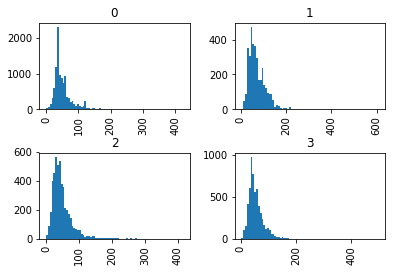

In [17]:
train_df['chars_in_subject_description'] = train_df['chars_in_subject'].apply(lambda x: 'none' if x <= 20 else 'few' if x <= 50 else 'many')
#train_df['chars_in_body'] = np.searchsorted(list(np.arange(0, max(train_df['chars_in_body']), 100)), train_df['chars_in_body'].values)
#train_df[train_df['label'] == 2]['chars_in_body'].value_counts().sort_index(ascending = False)
train_df.hist(column='chars_in_subject', by='label', bins = 75)

Text(0.5,1,'Class 3')

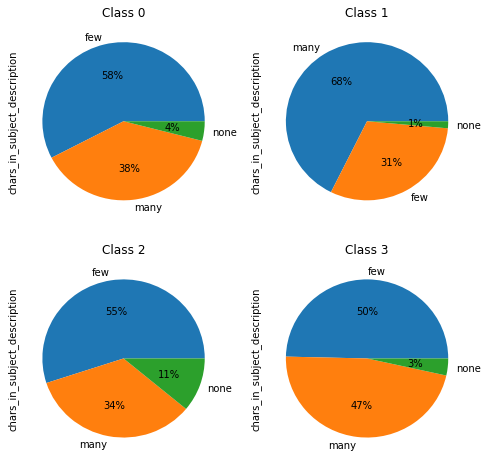

In [18]:
res0 = train_df[train_df['label'] == 0]['chars_in_subject_description'].value_counts()
res1 = train_df[train_df['label'] == 1]['chars_in_subject_description'].value_counts()
res2 = train_df[train_df['label'] == 2]['chars_in_subject_description'].value_counts()
res3 = train_df[train_df['label'] == 3]['chars_in_subject_description'].value_counts()

fig = plt.figure(figsize=(8,8))

fig.add_subplot(2, 2, 1)
res0.plot.pie(autopct='%1.0f%%')
plt.title('Class 0')
fig.add_subplot(2, 2, 2)
res1.plot.pie(autopct='%1.0f%%')
plt.title('Class 1')
fig.add_subplot(2, 2, 3)
res2.plot.pie(autopct='%1.0f%%')
plt.title('Class 2')
fig.add_subplot(2, 2, 4)
res3.plot.pie(autopct='%1.0f%%')
plt.title('Class 3')

In [4]:
train_df['designation'] = train_df['designation'].apply(lambda x: 100 if type(x) is not int else x)
#train_df.plot.pie(y='designation', by='label', bins=50, subplots=True)
train_df['org'] = train_df['org'].apply(lambda x: 'porn' if type(x) is str and 'porn' in x  else x)
train_df['org'] = train_df['org'].apply(lambda x: 'centralesupelec' if type(x) is str and ('geeps' in x or 'supelec' in x or 'student-cs' in x) else x)
train_df['org'] = train_df['org'].apply(lambda x: 'academia' if type(x) is str and ('usief' in x or 'acm' in x or 'iiitd' in x or 'inria' in x or 'researchgatemail' in x or 'researchgate' in x or 'academia' in x or 'ieee' in x or 'slack' in x or 'springboard' in x) else x)
train_df['org'] = train_df['org'].apply(lambda x: 'social_media' if type(x) is str and ('flickr'in x or 'social' in x or 'facebook' in x or 'twitter' in x or 'quora' in x or 'youtube' in x or 'pinterest' in x or 'medium' in x) else x)
train_df['org'] = train_df['org'].apply(lambda x: 'online_courses' if type(x) is str and ('nptel' in x or 'udemy' in x or 'mit'in x or 'classroom' in x or 'piazza' in x or 'duolingo' in x or 'learning' in x or 'edx' in x or 'coursera' in x or 'khanacademy' in x or 'usebackpack' in x)else x )
train_df['org'] = train_df['org'].apply(lambda x: 'google' if type(x) is str and ('google' in x )else x )

train_df['org'] = train_df['org'].apply(lambda x: 'coding' if type(x) is str and ('mapbox' in x or 'api' in x or 'php' in x or 'tech' in x or 'udacity' in x or 'evernote' in x or 'data' in x or 'stack' in x or 'sharelatex' in x or 'aws' in x or 'codalab' in x or 'trello' in x or 'overleaf' in x  or 'stackexchange' in x or 'hacker' in x or 'code' in x or 'kaggle' in x or 'github' in x or 'nvidia' in x or 'repository' in x ) else x)
train_df['org'] = train_df['org'].apply(lambda x: 'online_shopping' if type(x) is str and ('ebay' in x or 'amazon' in x) else x)
train_df['org'] = train_df['org'].apply(lambda x: 'work_media_offer' if type(x) is str and ('cocubes' in x or 'monsterindia' in x or 'job' in x or 'linkedin' in x or 'glassdoor' in x or 'hire' in x or 'career' in x) else x)
train_df['org'] = train_df['org'].apply(lambda x: 'email' if type(x) is str and ('mail' in x ) else x)
train_df['org'] = train_df['org'].apply(lambda x: 'travel' if type(x) is str and ('atlassian' in x or 'airfrance' in x or 'airindia' in x or 'airserbia' in x or 'thomascook' in x or 'easyjet' in x or 'ryanair' in x or 'uber' in x) else x)
train_df['org'] = train_df['org'].apply(lambda x: 'entertainment' if type(x) is str and ('audio' in x or 'audible' in x or 'video' in x or 'imdb' in x or 'cinema' in x or 'entertainment' in x or 'spotify' in x or 'music' in x or 'movies' in x) else x)
train_df['org'] = train_df['org'].apply(lambda x: 'offers_newsletters' if type(x) is str and ('indiatimes' in x or 'news' in x or 'coupon' in x or 'letter' in x or 'offer' in x)else x)
train_df['org'] = train_df['org'].apply(lambda x: 'softwares' if type(x) is str and ('app' in x or 'dropbox' in x or 'airtable' in x or 'splitwise' in x)else x)
train_df['org'] = train_df['org'].apply(lambda x: 'bank' if type(x) is str and ('kotak' in x or 'hsbc' in x or 'paytm' in x)else x)
train_df['org'] = train_df['org'].apply(lambda x: 'food' if type(x) is str and ('bigbasket' in x or 'food' in x )else x)
train_df['org'] = train_df['org'].apply(lambda x: 'other' if type(x) is str and (x not in ['food', 'bank', 'softwares', 'offers_newsletters', 'entertainment', 'travel', 'porn', 'centralesupelec', 'academia', 'social_media', 'online_courses', 'google', 'coding', 'online_shopping',  'work_media_offer', 'email'] )else x )


In [8]:
df_results = pd.DataFrame(train_df['org'].value_counts(), columns=['org'])
df_results.index.names = ['ID']
df_results.to_csv(data_dir + 'categories.csv')

res = train_df[train_df['label'] == 2]['org'].value_counts()
res

academia           4338
centralesupelec     235
coding              158
email                27
other                13
google                7
online_courses        6
Name: org, dtype: int64

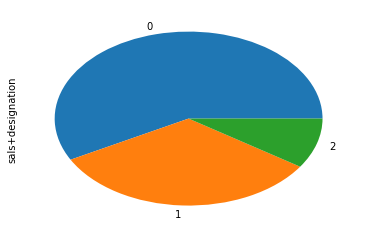

In [13]:
train_df['sals+designation'] = train_df['salutations'] +  train_df['designation']

res = train_df[train_df['label'] == 1]['sals+designation'].value_counts()
res.plot.pie()

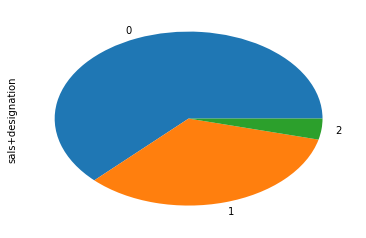

In [14]:
res = train_df[train_df['label'] == 0]['sals+designation'].value_counts()
res.plot.pie()

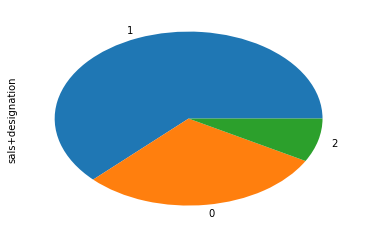

In [15]:
res = train_df[train_df['label'] == 2]['sals+designation'].value_counts()
res.plot.pie()

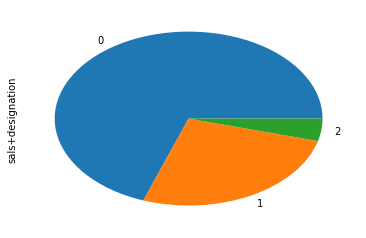

In [16]:
res = train_df[train_df['label'] == 3]['sals+designation'].value_counts()
res.plot.pie()

In [47]:
train_df['sals+designation'] = train_df['salutations'] + train_df['designation'] 

In [11]:
from dateutil import parser 
for x in train_df['date']: # get rid of (GMT+) elements -> already encoded
    if '(GMT+' in x :
        train_df = train_df.replace({'date': {x: x.split('(')[0]}})


    # df['date'] = pd.to_datetime(df['date'], utc = True)
    # df['month'] = df['date'].dt.month
    # df['year'] = df['date'].dt.year
    # df['day'] = df['date'].dt.date
    # df['hour'] = df['date'].dt.hour

train_df['date_time'] = [parser.parse(x) for x in train_df['date']]
train_df['time_zone'] = [str(x)[-6:] for x in train_df['date_time']]

Text(0.5,1,'Class 3')

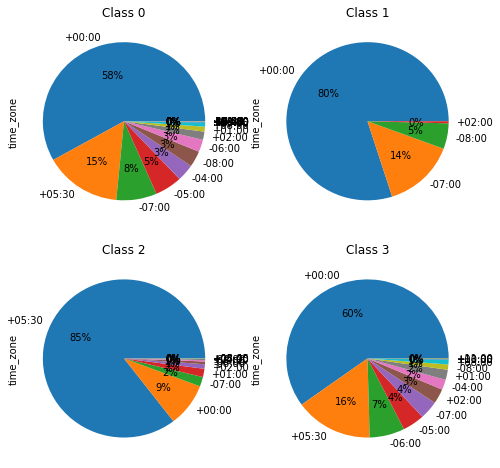

In [12]:
res0 = train_df[train_df['label'] == 0]['time_zone'].value_counts()
res1 = train_df[train_df['label'] == 1]['time_zone'].value_counts()
res2 = train_df[train_df['label'] == 2]['time_zone'].value_counts()
res3 = train_df[train_df['label'] == 3]['time_zone'].value_counts()

fig = plt.figure(figsize=(8,8))

fig.add_subplot(2, 2, 1)
res0.plot.pie(autopct='%1.0f%%')
plt.title('Class 0')
fig.add_subplot(2, 2, 2)
res1.plot.pie(autopct='%1.0f%%')
plt.title('Class 1')
fig.add_subplot(2, 2, 3)
res2.plot.pie(autopct='%1.0f%%')
plt.title('Class 2')
fig.add_subplot(2, 2, 4)
res3.plot.pie(autopct='%1.0f%%')
plt.title('Class 3')